# Data source
<br> Kpop Database https://dbkpop.com/ (scraping with scrape_data.ipynb)
<br> Spotify dataset https://www.kaggle.com/datasets/yamaerenay/spotify-dataset-19212020-600k-tracks

# 1. Data Preparation

In [2]:
import pandas as pd
import numpy as np
from ast import literal_eval
from datetime import date, datetime

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

/home/danannisar/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load the datasets
spotify_artist_csv = pd.read_csv('data/artists.csv')
spotify_tracks_csv = pd.read_csv('data/tracks.csv')
kpop_gg_csv = pd.read_csv('data/kpop_gg.csv')
kpop_bg_csv = pd.read_csv('data/kpop_bg.csv')
kpop_idols_csv = pd.read_csv('data/kpop_all_idols.csv')

### a. Preparation for Spotify Data

In [4]:
# Rename spotify data columns, convert to proper data types, and normalize string data types
spotify_artist = spotify_artist_csv.rename(columns = {'id': 'id_artists', 'name': 'artists', 'popularity': 'artist_popularity'})

# Filter only kpop genre artists
k_genres = ["'k-pop'", "'k-pop girl group'", "'korean ost'", "'korean city pop'", "'korean pop'", "'classic k-pop'", "'k-pop boy group'", "'korean r&b'", "'k-rock'", "'k-rap'"]  
k_genres_list = '|'.join(k_genres)
spotify_kpop_artist = spotify_artist.loc[spotify_artist['genres'].str.contains(k_genres_list, case=False)].reset_index(drop = True)
spotify_kpop_artist['artists'] = spotify_kpop_artist['artists'].str.lower()

# Rename column names of spotify_tracks
spotify_tracks = spotify_tracks_csv.rename(columns = {'id': 'id_tracks', 'name': 'tracks_name', 'popularity': 'tracks_popularity', 'mode': 'modality'})

# convert datetime column
spotify_tracks['release_date'] = pd.to_datetime(spotify_tracks['release_date'])

# explode artists column because there are songs performed by more than one artists, just get the most popular artist
spotify_tracks['id_artists'] = spotify_tracks['id_artists'].apply(literal_eval)
exploded_tracks = spotify_tracks.explode('id_artists').drop_duplicates()


### b. Preparation for Kpop Data

In [5]:
# Rename columns
kpop_groups_csv = pd.concat([kpop_gg_csv, kpop_bg_csv])
kpop_groups = kpop_groups_csv.rename(columns = {'Name': 'group', 'Debut': 'debut', 'Company': 'company', 'Members': 'members', 'Orig. Memb.': 'orig_members', 'Active': 'active'})

# If the group happened to lose one or more member
kpop_groups['members_lost'] = (kpop_groups['members'] - kpop_groups['orig_members'] < 0).astype(int)

# if the group is on hiatus change to active
kpop_groups['active'] = kpop_groups.loc[kpop_groups['active'] == 'hiatus', 'active'] = 'active'
kpop_groups['group'] = kpop_groups['group'].str.lower()
kpop_groups['debut'] = pd.to_datetime(kpop_groups['debut'])
kpop_groups = kpop_groups[['group', 'debut', 'company', 'members_lost', 'active']]

# check if group comes from big company
big5_companies = ['JYP', 'SM', 'YG', 'HYBE', 'Big Hit', 'Be:lift', 'Cube']
big5_list = '|'.join(big5_companies)
kpop_groups['big5_company'] = kpop_groups.company.str.contains(big5_list)

In [6]:
# Rename kpop_idols data columns, grouping to see average and std of age for each group
kpop_idols = kpop_idols_csv.rename(columns = {'Stage Name': 'stage_name', 'Group': 'group', 'Other Group': 'other_group', 'Date of Birth': 'birth_date', 'Gender': 'gender'})
kpop_idols['group'] = kpop_idols['group'].str.lower()
kpop_idols.loc[kpop_idols['group'] == "tvxq", 'group'] = "tvxq!"
kpop_idols.loc[kpop_idols['group'] == "cosmic girls", 'group'] = "wjsn"
kpop_idols['other_group'] = kpop_idols['other_group'].str.lower()
kpop_idols = (
 kpop_idols.assign(other_group=kpop_idols['other_group'].str.split(','))
   .explode('other_group')
   .reset_index(drop=True)
)
kpop_idols = kpop_idols[['stage_name', 'group', 'other_group', 'birth_date', 'gender']]
kpop_idols['birth_date'] = pd.to_datetime(kpop_idols['birth_date'])

In [7]:
max_date = spotify_tracks['release_date'].max()

# Function to get days difference from track's release date
def datediff(debut, release):
    diff_days = (release-debut).days
    return diff_days

# Function to get average age of the group
def mean_group_age(kpop_idols, group, release_date):

    if (group in kpop_idols.group.tolist()):
        kpop_idols = kpop_idols[kpop_idols.group == group].reset_index(drop= True)
        kpop_idols['release_date'] = release_date
        age_group = []
        for i in range(len(kpop_idols)):
            birthdate = kpop_idols.loc[i, 'birth_date']
            today = kpop_idols.loc[i, 'release_date']
            age = today.year - birthdate.year - ((today.month, today.day) < (birthdate.month, birthdate.day))
            age_group.append(age)
       
    elif (group in kpop_idols.other_group.tolist()):
        kpop_idols = kpop_idols[kpop_idols.other_group == group].reset_index(drop= True)
        kpop_idols['release_date'] = release_date
        age_group = []
        for i in range(len(kpop_idols)):
            birthdate = kpop_idols.loc[i, 'birth_date']
            today = kpop_idols.loc[i, 'release_date']
            age = today.year - birthdate.year - ((today.month, today.day) < (birthdate.month, birthdate.day))
            age_group.append(age)
    
    else:
        age_group = np.nan
    
    return np.mean(age_group)


### c. Merge Spotify and Kpop Data (Inner Join)

In [8]:
# Get kpop groups that listed in Spotify music platform
spotify_kpop_artist_v2 = pd.merge(spotify_kpop_artist, kpop_groups, how = 'inner', right_on='group', left_on = 'artists')
spotify_kpop_tracks = pd.merge(exploded_tracks.drop('artists', axis = 1), spotify_kpop_artist_v2, how = 'inner', on = ['id_artists'])

# Get new columns : days_after_debut (days difference from debut date and released date) 
# and mean_age_released (average age of all members when the track released)
spotify_kpop_tracks['days_after_debut'] = spotify_kpop_tracks.apply(lambda row: datediff(row['debut'], row['release_date']), axis=1)
spotify_kpop_tracks['days_after_debut'] = np.where(spotify_kpop_tracks['days_after_debut'] < 0, 0,spotify_kpop_tracks['days_after_debut'] )
spotify_kpop_tracks['mean_age_released'] = spotify_kpop_tracks.apply(lambda row: mean_group_age(kpop_idols, row['group'], row['release_date']), axis=1)

spotify_kpop_df = spotify_kpop_tracks[['id_tracks', 'tracks_name', 'id_artists', 'artists', 'group',
        'tracks_popularity', 'artist_popularity', 'duration_ms', 'explicit',  'release_date', 'danceability', 'energy',
        'time_signature', 'loudness', 'modality', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'key',
        'followers', 'debut', 'release_date', 'active', 'big5_company', 'days_after_debut', 'mean_age_released']]

## 2. Exploratory Data Analysis

Several columns that gonna used in this analysis:
- `tracks_popularity`: popularity of track in range 0-100 
- `artist_popularity`: popularity of artist in range 0-100 
- `duration_ms`: duration of the song (milisecond)
- `explicit`: whether it contains explicit content or not
- `danceability`: how danceable a song is in range 0-1
- `energy`: how energized a song is in range 0-1
- `time_signature`: major note of track [0:C, 1:C#, 2:D, ...] using Pitch Class notation
- `loudness`: how loud a song is in db
- `mode`: the modality of track (0: minor, 1: major)
- `speechiness`: the presence of spoken words in track range 0-1
- `acousticness`: how acoustic a track is in range 0-1
- `instrumentalness`: the absence of vocal sounds in track in range 0-1
- `liveness`: the presence of audience in track in range 0-1
- `the valence`: positiveness of the track in range 0-1 (high valence means the track sounds more positive, happy, cheerful or euphoric)
- `tempo`: overal tempo of track in BPM
- `time_signature`: a sign used in music to indicate meter of composition (mostly 4)
- `followers`: amount followers the group has in spotify
- `big4_company`: condition if the group comes from current big entertainment company (SM, JYP, YG, or HYBE/Big Hit)
- `active`: condition if the group still active or not
- `days_after_debut`: how many days the track released after the group's debut
- `mean_age_released`: average of the member's age when the track was released


In [9]:
# see each column data
# if using trees method, some columns like explicit

used_columns = ['tracks_popularity', 'artist_popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
        'time_signature', 'loudness', 'modality', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'key',
        'followers', 'big5_company', 'days_after_debut', 'mean_age_released'] 

for col in used_columns:
    print(col)
    print(spotify_kpop_df[col].unique()[:5])
    print(spotify_kpop_df[col].nunique())
    print()

tracks_popularity
[56 38 31 40 62]
65

artist_popularity
[48 73 69 53 96]
39

duration_ms
[205000 281760 236733 201867 213827]
868

explicit
[0 1]
2

danceability
[0.751 0.638 0.554 0.809 0.716]
383

energy
[0.912 0.781 0.907 0.883 0.779]
400

time_signature
[4 3 5]
3

loudness
[-1.822 -6.364 -6.052 -5.176 -2.203]
821

modality
[0 1]
2

speechiness
[0.0391 0.0519 0.316  0.214  0.0805]
545

acousticness
[0.0247 0.0334 0.0698 0.0142 0.178 ]
668

instrumentalness
[0.00e+00 3.51e-04 1.16e-06 5.01e-04 4.27e-05]
223

liveness
[0.0778 0.085  0.121  0.12   0.167 ]
512

valence
[0.804 0.813 0.53  0.888 0.59 ]
519

tempo
[108.002  87.994 180.024 105.119  99.977]
869

key
[5 7 2 9 1]
12

followers
[  231724.  2259111.  1980623.   158646. 31623813.]
76

big5_company
[True False]
2

days_after_debut
[1438  556 1165   95  512]
405

mean_age_released
[21.83333333 19.16666667 20.83333333 16.25       17.5       ]
199



### a. Convert categorical data to more proper form and types

In [10]:
# Filter to columns that wanted to be analyzed
df = spotify_kpop_df[used_columns]

# Convert data to proper form and types
explicit_ls = {1: 'explicit', 0: 'non_explicit'}
df.explicit= df.explicit.map(explicit_ls)

pitch_class_ls = {0: 'C', 1: 'C#', 2: 'D', 3: 'D#', 4: 'E', 5: 'F', 6: 'F#', 7: 'G', 8: 'G#', 9: 'A', 10: 'A#', 11: 'B'}
df.key = df.key.map(pitch_class_ls)

mode_ls = {0: 'minor', 1: 'major'}
df.modality = df.modality.map(mode_ls)

df[['time_signature', 'modality', 'key', 'big5_company']] =  df[['time_signature', 'modality', 'key', 'big5_company']].astype(str)
df.dtypes

tracks_popularity      int64
artist_popularity      int64
duration_ms            int64
explicit              object
danceability         float64
energy               float64
time_signature        object
loudness             float64
modality              object
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
tempo                float64
key                   object
followers            float64
big5_company          object
days_after_debut       int64
mean_age_released    float64
dtype: object

In [11]:
# Get numerical and categorical variable names
numerical_columns = list(df.dtypes[df.dtypes != "object"].index)
categorical_columns = list(df.dtypes[df.dtypes == "object"].index)
base = numerical_columns + categorical_columns
numerical_columns.remove('tracks_popularity')
base.remove('tracks_popularity')
len(base)

19

### b. Check if theres missing values

The missing value is `mean_age_released` or average age at released date of each group, there are 6 groups who can't be found in database. This variable is pretty hard to be estimated with values like mean or median, also it's impossible to be 0, so it needs to be dropped.

In [12]:
df.isna().sum()

tracks_popularity     0
artist_popularity     0
duration_ms           0
explicit              0
danceability          0
energy                0
time_signature        0
loudness              0
modality              0
speechiness           0
acousticness          0
instrumentalness      0
liveness              0
valence               0
tempo                 0
key                   0
followers             0
big5_company          0
days_after_debut      0
mean_age_released    23
dtype: int64

In [13]:
df = df.dropna(axis = 0)
df.sort_values(by = 'mean_age_released')

,tracks_popularity,artist_popularity,duration_ms,explicit,danceability,energy,time_signature,loudness,modality,speechiness,acousticness,instrumentalness,liveness,valence,tempo,key,followers,big5_company,days_after_debut,mean_age_released
759,45,50,241867,non_explicit,0.518,0.708,4,-4.389,minor,0.0375,0.2520,0.000000,0.1760,0.220,119.847,C,368163.0,False,1,15.40
23,42,73,290293,non_explicit,0.737,0.575,4,-5.784,minor,0.0402,0.4040,0.000005,0.0699,0.478,133.957,C#,2259111.0,True,0,16.00
14,54,73,216453,non_explicit,0.724,0.792,4,-2.219,major,0.0840,0.1490,0.000002,0.1100,0.580,100.009,C#,2259111.0,True,0,16.00
766,42,55,228960,non_explicit,0.756,0.806,4,-3.867,minor,0.0428,0.2250,0.000000,0.1040,0.742,109.956,C,667220.0,True,19,16.00
13,53,73,314867,non_explicit,0.516,0.496,4,-5.784,major,0.0290,0.5170,0.000000,0.1470,0.314,75.621,C#,2259111.0,True,95,16.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682,56,62,216735,non_explicit,0.478,0.292,4,-8.161,major,0.0312,0.8940,0.000000,0.1210,0.208,131.831,G#,555680.0,False,4346,31.50
39,58,69,201112,non_explicit,0.711,0.885,4,-3.299,minor,0.0477,0.0044,0.000000,0.2070,0.866,121.978,F,1980623.0,True,4383,31.60
40,50,69,255012,non_explicit,0.531,0.634,4,-5.676,major,0.0325,0.1190,0.000000,0.2530,0.312,73.955,G,1980623.0,True,4383,31.60
683,59,62,201267,non_explicit,0.382,0.348,4,-6.694,major,0.0345,0.7290,0.000000,0.1000,0.290,131.082,G#,555680.0,False,4654,32.50


### c. Plot to see the spreading of track and artist popularity in Histogram

The artist and track popularity seems to follow normality distribution, no long tail in distribution, <br>so there's no need to transform the popularity with logarithmic form.

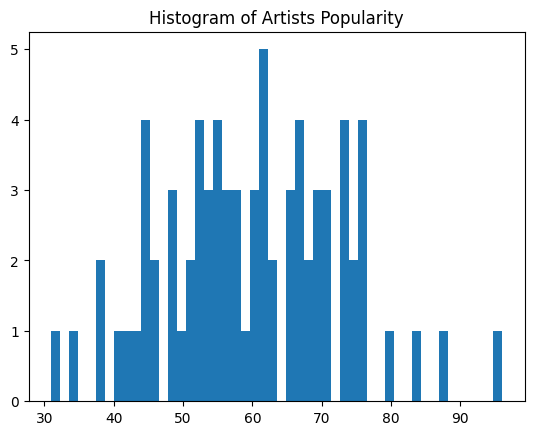

In [14]:
df_artist = spotify_kpop_df.drop_duplicates(subset=['artists'])
plt.hist(df_artist.artist_popularity, bins = 50)
plt.title("Histogram of Artists Popularity")
plt.show()

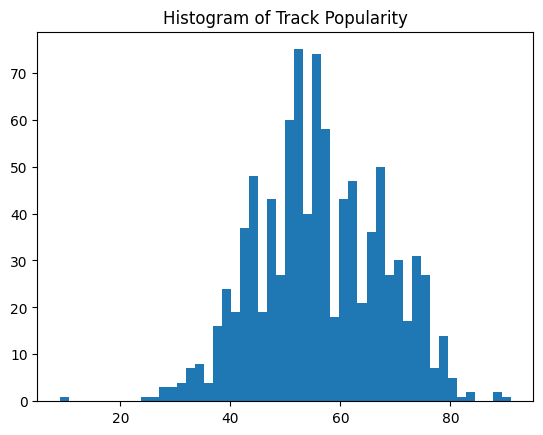

In [15]:
plt.hist(df.tracks_popularity, bins = 50)
plt.title("Histogram of Track Popularity")
plt.show()
#sns.histplot(df.artist_popularity, bins = 50)

### d. Heatmap of Correlation Plot between Dependent and Independent Variables

Divided into two heatmap, the first one is correlation between `track_popularity` and `main_features` of track (popularity, followers, days from debut, and age when track was released). The second one is correlation between `track_popularity` and the musicality feature of the track.

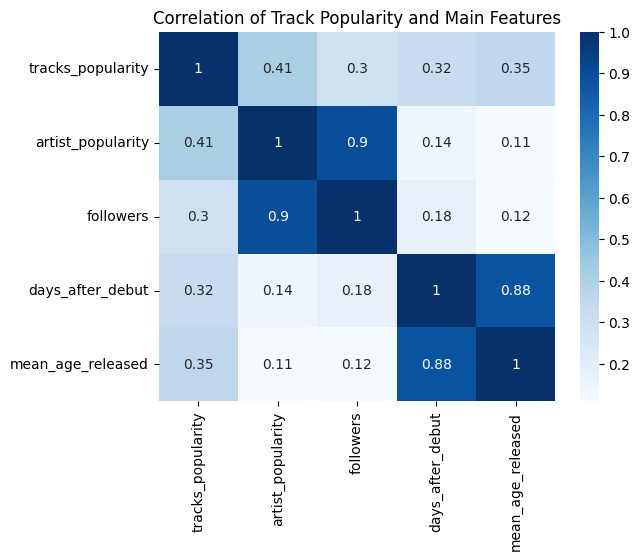

In [16]:
main_features=['tracks_popularity', 'artist_popularity', 'followers', 'days_after_debut', 'mean_age_released']
corr = df[main_features].corr()

ax = plt.axes()
corr_plot = sns.heatmap(corr, cmap="Blues", annot=True, ax = ax)
ax.set_title('Correlation of Track Popularity and Main Features')
plt.show()


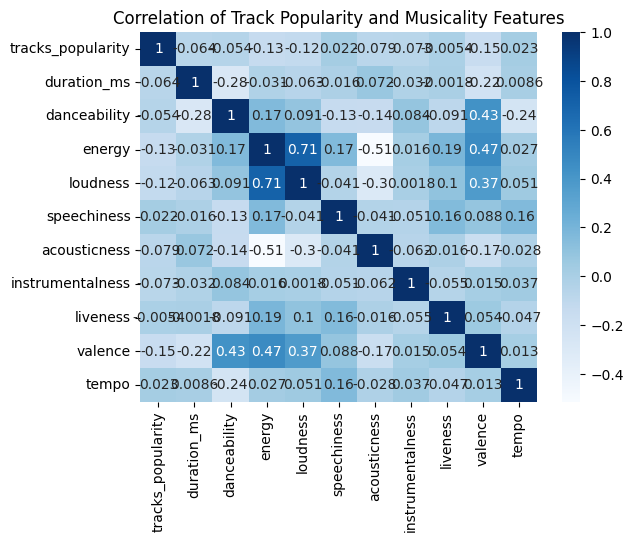

In [17]:
musicality_feature = ['tracks_popularity', 'duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
corr = df[musicality_feature].corr()

ax = plt.axes()
corr_plot = sns.heatmap(corr, cmap="Blues", annot=True, ax = ax)
ax.set_title('Correlation of Track Popularity and Musicality Features')
plt.show()

### EDA categorical variables

- For `explicit` and `time_signature` variables, the explicit tracks is just a small portion so it could be dropped as the independent variable
- For `big5_company`, `key`, `modality` variable it gonna be used as independent variables, because there's slightly difference in tracks_popularity spread

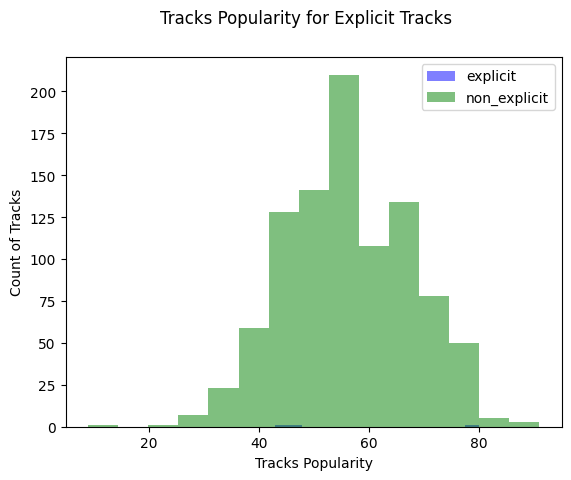

In [18]:
# EDA for explicit column

fig, ax = plt.subplots()

ax.hist(df[df["explicit"]=="explicit"]["tracks_popularity"], bins=15, alpha=0.5, color="blue", label="explicit")
ax.hist(df[df["explicit"]=="non_explicit"]["tracks_popularity"], bins=15, alpha=0.5, color="green", label="non_explicit")

ax.set_xlabel("Tracks Popularity")
ax.set_ylabel("Count of Tracks")

fig.suptitle("Tracks Popularity for Explicit Tracks")

ax.legend();

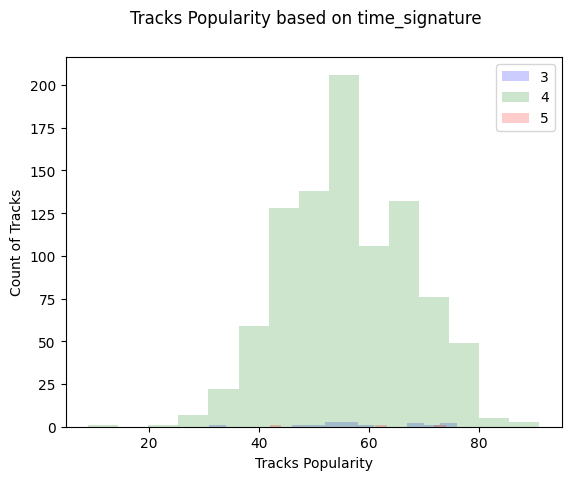

In [19]:
# Tracks Popularity based on time_signature
fig, ax = plt.subplots()

ax.hist(df[df["time_signature"]=="3"]["tracks_popularity"], bins=15, alpha=0.2, color="blue", label="3")
ax.hist(df[df["time_signature"]=="4"]["tracks_popularity"], bins=15, alpha=0.2, color="green", label="4")
ax.hist(df[df["time_signature"]=="5"]["tracks_popularity"], bins=15, alpha=0.2, color="red", label="5")

ax.set_xlabel("Tracks Popularity")
ax.set_ylabel("Count of Tracks")

fig.suptitle("Tracks Popularity based on time_signature")

ax.legend();

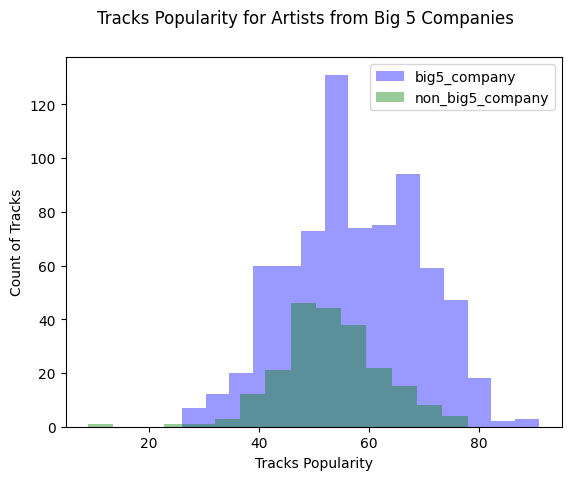

In [20]:
## EDA categorical variables based on company
fig, ax = plt.subplots()

ax.hist(df[df["big5_company"]=="True"]["tracks_popularity"], bins=15, alpha=0.4, color="blue", label="big5_company")
ax.hist(df[df["big5_company"]=="False"]["tracks_popularity"], bins=15, alpha=0.4, color="green", label="non_big5_company")

ax.set_xlabel("Tracks Popularity")
ax.set_ylabel("Count of Tracks")

fig.suptitle("Tracks Popularity for Artists from Big 5 Companies")

ax.legend();

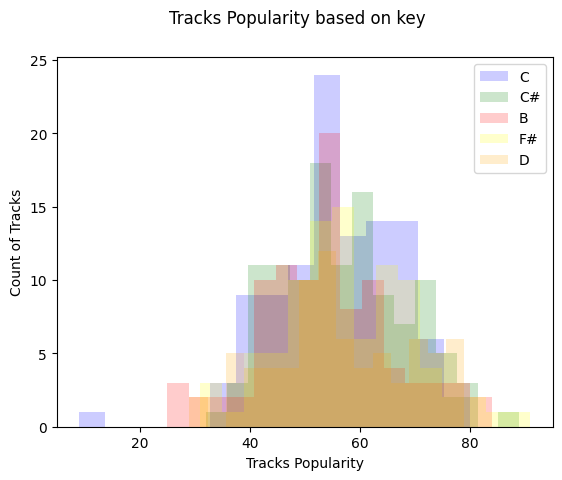

In [21]:
#Tracks Popularity based on key

fig, ax = plt.subplots()

ax.hist(df[df["key"]=="C"]["tracks_popularity"], bins=15, alpha=0.2, color="blue", label="C")
ax.hist(df[df["key"]=="C#"]["tracks_popularity"], bins=15, alpha=0.2, color="green", label="C#")
ax.hist(df[df["key"]=="B"]["tracks_popularity"], bins=15, alpha=0.2, color="red", label="B")
ax.hist(df[df["key"]=="F#"]["tracks_popularity"], bins=15, alpha=0.2, color="yellow", label="F#")
ax.hist(df[df["key"]=="D"]["tracks_popularity"], bins=15, alpha=0.2, color="orange", label="D")

ax.set_xlabel("Tracks Popularity")
ax.set_ylabel("Count of Tracks")

fig.suptitle("Tracks Popularity based on key")

ax.legend();

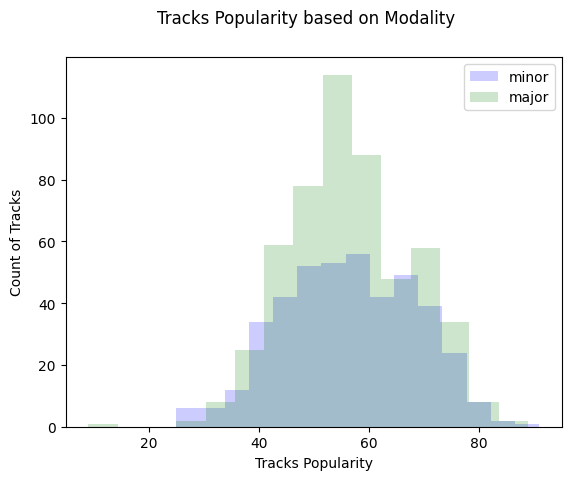

In [22]:
#Tracks Popularity based on modality

fig, ax = plt.subplots()

ax.hist(df[df["modality"]=="minor"]["tracks_popularity"], bins=15, alpha=0.2, color="blue", label="minor")
ax.hist(df[df["modality"]=="major"]["tracks_popularity"], bins=15, alpha=0.2, color="green", label="major")

ax.set_xlabel("Tracks Popularity")
ax.set_ylabel("Count of Tracks")

fig.suptitle("Tracks Popularity based on Modality")

ax.legend();

# 3. Split Data set to Train, Validation, and Test 

In [151]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


In [152]:
# Separate y column or dependent variable
y_train = df_train.tracks_popularity.values
y_val = df_val.tracks_popularity.values
y_test = df_test.tracks_popularity.values

In [153]:
# delete dependent variable from X dataframe
del df_train['tracks_popularity']
del df_val['tracks_popularity']
del df_test['tracks_popularity']

In [26]:
categorical_columns.remove('explicit')
categorical_columns.remove('time_signature')
base = numerical_columns + categorical_columns

# 4. Linear Regression

Before trying more complex model, try the most simple one which is Linear Regression.

In [27]:
# Prepare independent variables data
categories = {}

for c in categorical_columns:
    categories[c] = list(df[c].value_counts().head().index)

def prepare_X(df):
    df = df.copy()
    features = base.copy()
        
    for c, values in categories.items():
        for v in values:
            df['%s_%s' % (c, v)] = (df[c] == v).astype('int')
            features.append('%s_%s' % (c,v))

    X = df.values
    
    df_num = df[numerical_columns]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

# Function to train the model
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    return w_full[0], w_full[1:]

# Function to train the linear regression model using regularization
def train_linear_regression_reg(X, y, r = 0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    return w_full[0], w_full[1:]

# Function to calculate accuracy using RMSE metric
def rmse(y, y_pred):
    error = y - y_pred
    se = error ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [28]:
# Train using linear regression method without regularization
X_train = prepare_X(df_train)
w0,w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)

round(rmse(y_val, y_pred),2)

9.67

In [30]:
# Train using linear regression with regularization
for r in [0.0, 0.00001, 0.0001, 0.001, 0.1, 1, 10]:
    X_train = prepare_X(df_train)
    w0,w = train_linear_regression_reg(X_train, y_train, r = r)
    X_val = prepare_X(df_val)
    y_pred = w0 + X_val.dot(w)

    score = rmse(y_val, y_pred)
    print(r, w0, score)

0.0 -11.236421217972772 9.667404909594888
1e-05 -11.236278575334405 9.667402547152784
0.0001 -11.234993935304097 9.667381342988154
0.001 -11.222066576780687 9.667174809818944
0.1 -9.798534524714182 9.65756599639923
1 -4.590769742304892 9.630768551834233
10 -0.765589218760375 9.615593903947264


The best regularization parameter is 1.

# 4. Regression using Trees Method

## a. Decision tree

In [31]:
# Preparation training data
features = base.copy()
train_dicts = df_train[features].to_dict(orient='records')
val_dicts = df_val[features].to_dict(orient='records')

dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [32]:
# Fitting using Decision Tree with initial max_depth = 3
dt = DecisionTreeRegressor(max_depth=3)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3)

In [33]:
# Inspection the trees
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- artist_popularity <= 61.50
|   |--- artist_popularity <= 36.00
|   |   |--- value: [9.00]
|   |--- artist_popularity >  36.00
|   |   |--- mean_age_released <= 22.10
|   |   |   |--- value: [44.62]
|   |   |--- mean_age_released >  22.10
|   |   |   |--- value: [51.88]
|--- artist_popularity >  61.50
|   |--- mean_age_released <= 22.18
|   |   |--- followers <= 4567627.50
|   |   |   |--- value: [60.04]
|   |   |--- followers >  4567627.50
|   |   |   |--- value: [53.86]
|   |--- mean_age_released >  22.18
|   |   |--- followers <= 14813564.50
|   |   |   |--- value: [60.65]
|   |   |--- followers >  14813564.50
|   |   |   |--- value: [68.30]



In [34]:
# Calculating mean squared error
y_pred = dt.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred)).round(2)

9.51

In [36]:
# Looping to choose the best max_depth and min_samples_leaf
# From the result, the best parameter for max_depth is 4 and min_samples_leaf = 15
scores = []
for d in [2, 3, 4, 5, 6, 7, 8,10, 20]:
    for s in [1,2,5,10,15,20,100,200,500]:

        dt = DecisionTreeRegressor(max_depth = d, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred)).round(4)

        scores.append((d,s,rmse))

In [37]:
df_scores = pd.DataFrame(scores, columns = ['max_depth', 'min_samples_leaf', 'rmse'])
df_scores.sort_values(by = 'rmse').head()

,max_depth,min_samples_leaf,rmse
22,4,15,9.2186
18,4,1,9.2461
31,5,15,9.2944
21,4,10,9.3118
29,5,5,9.3297


## b. Random Forest

In [38]:
# Training random forest model
rf = RandomForestRegressor(n_estimators=30, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=30, n_jobs=-1, random_state=1)

In [39]:
# Calculating rmse
y_pred = rf.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred)).round(2)

9.83

### Decide the best `n_estimator` parameter

100%|██████████| 20/20 [00:34<00:00,  1.70s/it]


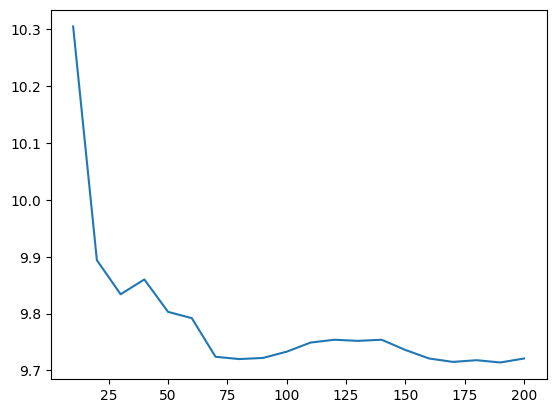

In [40]:
from tqdm.auto import tqdm
# Training random forest model with various range of n_estimator
scores = []
for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

#@ INSPECTING THE RMSE SCORES:
plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))

100%|██████████| 6/6 [01:37<00:00, 16.28s/it]


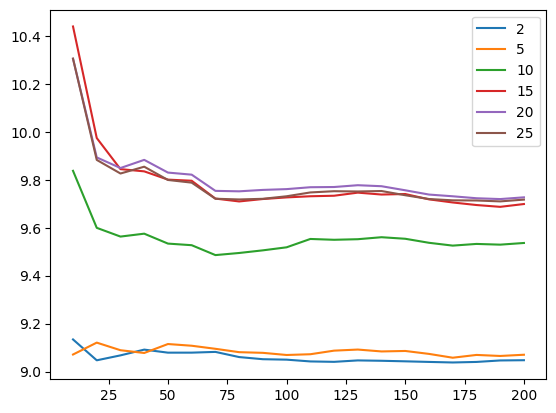

In [41]:
scores = []
# Training random forest model with various range of n_estimator and max_depth
for d in tqdm([2, 5, 10, 15, 20, 25]):
    
    for n in tqdm(range(10, 201, 10)):
        rf = RandomForestRegressor(n_estimators=n,max_depth=d,random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))

        scores.append((d, n, score))

columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

for d in [2, 5, 10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)

plt.legend()

### Decide the best parameter value for `min_samples_leaf`

In [82]:
max_depth = 2
scores = []
# Training random forest model with various range of n_estimator and min_samples_leaf
for s in tqdm([1, 3, 5, 10, 25, 50]):
    for n in tqdm(range(10, 201, 10)):
        rf = RandomForestRegressor(n_estimators=n, max_depth = max_depth, min_samples_leaf = s, random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))

        scores.append((s, n, score))

100%|██████████| 6/6 [00:37<00:00,  6.18s/it]


In [83]:
df_scores = pd.DataFrame(scores, columns = ['min_samples_leaf', 'n_estimators', 'score'])

colors = ['black', 'blue', 'orange', 'red', 'grey', 'yellow']
min_samples_leaf_values = [1, 3, 5, 10, 25, 50]
list(zip(min_samples_leaf_values, colors))

[(1, 'black'),
 (3, 'blue'),
 (5, 'orange'),
 (10, 'red'),
 (25, 'grey'),
 (50, 'yellow')]

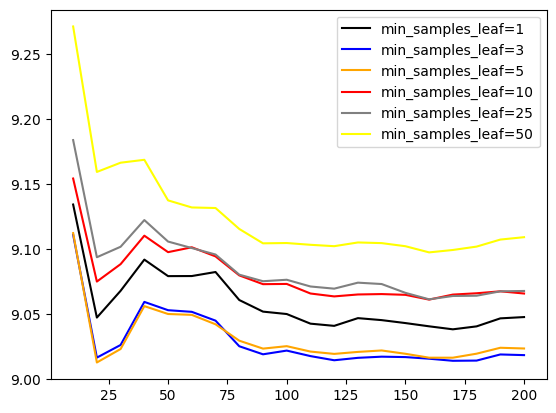

In [84]:
for s, col in zip(min_samples_leaf_values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    plt.plot(df_subset.n_estimators, df_subset.score, color = col,
    label = 'min_samples_leaf=%d' % s)

plt.legend()


In [85]:
#@ TRAINING THE RANDOM FOREST MODEL:
rf = RandomForestRegressor(n_estimators=100, max_depth=2, min_samples_leaf=3,
                           random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

features = dv.get_feature_names()
importance = rf.feature_importances_
df_feature_imp = pd.DataFrame(list(zip(features, importance)), columns = ['Feature', 'Importance_Val'])
df_feature_imp.sort_values(by='Importance_Val', ascending=False).head()

,Feature,Importance_Val
1,artist_popularity,0.521019
24,mean_age_released,0.288959
5,days_after_debut,0.133009
8,followers,0.036802
6,duration_ms,0.014967


## c. XG Boost

In [46]:
#@ CREATING THE DMARTIX:
import re
features = dv.get_feature_names()

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [47]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [48]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

### Parameter tuning for learning rate or `eta`: [0.1, 0.3]

In [93]:
scores = {}

In [94]:
%%capture output

# for eta = 0.1
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    #'objective': 'reg:squaredlogerror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [95]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

In [96]:
%%capture output
# for eta = 0.3
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    #'objective': 'reg:squaredlogerror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [97]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

In [98]:
scores.keys()

dict_keys(['eta=0.1', 'eta=0.3'])

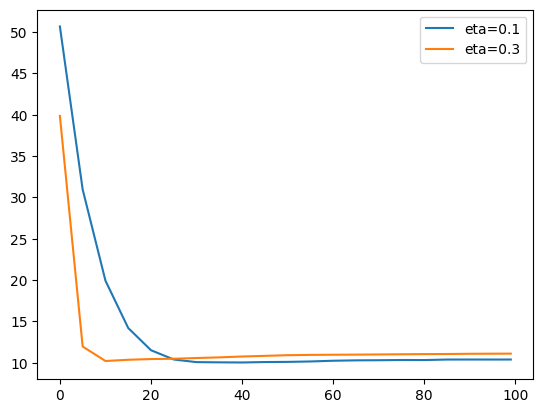

In [99]:
etas = ['eta=0.1', 'eta=0.3']
for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_iter, df_score.val_auc, label=eta)

plt.legend()


### Use learning rate or `eta=0.1`

### Parameter tuning for `max_depth`

In [117]:
scores = {}

In [118]:
%%capture output
# For max_dept = 2, 5, 15
xgb_params = {
    'eta': 0.1, 
    'max_depth': 2,
    'min_child_weight': 1,

    #'objective': 'reg:squarederror',
    'objective': 'reg:squaredlogerror',    
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [119]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)

In [120]:
%%capture output
# For max_dept = 2, 5, 15
xgb_params = {
    'eta': 0.1, 
    'max_depth': 5,
    'min_child_weight': 1,

    #'objective': 'reg:squarederror',
    'objective': 'reg:squaredlogerror',    
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [121]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)

In [122]:
%%capture output
# For max_dept = 2, 5, 15
xgb_params = {
    'eta': 0.1, 
    'max_depth': 15,
    'min_child_weight': 1,

    #'objective': 'reg:squarederror',
    'objective': 'reg:squaredlogerror',    
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [123]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)

In [124]:
scores.keys()

dict_keys(['max_depth=2', 'max_depth=5', 'max_depth=15'])

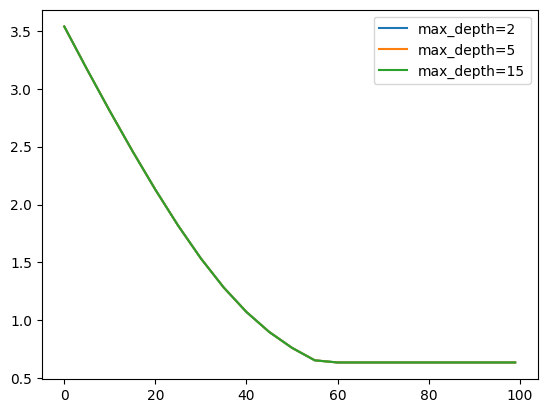

In [125]:
max_depths = ['max_depth=2', 'max_depth=5', 'max_depth=15']
for max_depth in max_depths:
    df_score = scores[max_depth]
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

plt.legend()


### Tuning parameter for `min_child_weigth`

In [109]:
scores = {}

In [110]:
%%capture output
# For min_child_weigth
xgb_params = {
    'eta': 0.1, 
    'max_depth': 2,
    'min_child_weight': 1,

    #'objective': 'reg:squarederror',
    'objective': 'reg:squaredlogerror', 
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [111]:

key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=1'

In [112]:
%%capture output
# For min_child_weigth
xgb_params = {
    'eta': 0.1, 
    'max_depth': 2,
    'min_child_weight': 10,

    #'objective': 'reg:squarederror',
    'objective': 'reg:squaredlogerror', 
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [113]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)

In [114]:
%%capture output
# For min_child_weigth
xgb_params = {
    'eta': 0.1, 
    'max_depth': 2,
    'min_child_weight': 30,

    #'objective': 'reg:squarederror',
    'objective': 'reg:squaredlogerror', 
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [115]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)

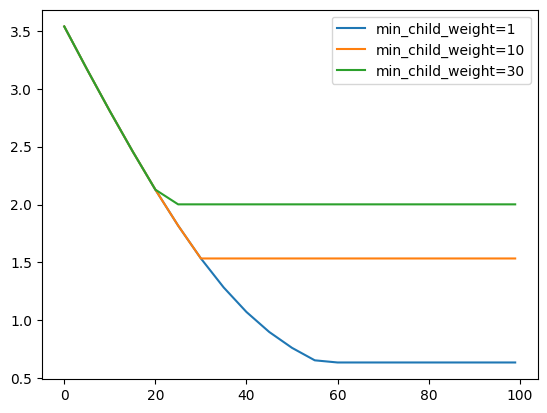

In [116]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)

plt.legend()

### Final XGB model

In [127]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 2,
    'min_child_weight': 1,

    'objective': 'reg:squaredlogerror',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100)

# 5. Selecting Final Model

Select Random Forest as the best accuracy with train model

### a. Decision Tree

In [154]:
dt = DecisionTreeRegressor(max_depth=4, min_samples_leaf=15)
dt.fit(X_train, y_train)

#@ CALCULATING MEAN SQUARED ERROR:
y_pred = dt.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred))

9.21860794677278

### b. Random Forest

In [155]:
rf = RandomForestRegressor(n_estimators=100, max_depth=2, min_samples_leaf=3, random_state=1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
score = np.sqrt(mean_squared_error(y_val, y_pred))
score

9.02163320556207

### c. XG Boost

In [158]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 2,
    'min_child_weight': 1,

    # reg:squaredlogerror: regression with squared log loss 1/2[log(pred+1)−log(label+1)]2. 
    # - All input labels are required to be greater than -1.
    'objective': 'reg:squarederror',
    
    #'booster': 'gblinear',
    #'tree_method': 'gpu_hist',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100)

In [159]:
y_pred = model.predict(dval)
score = np.sqrt(mean_squared_error(y_val, y_pred))
score

9.030441206318757

## Train with full train data then predict with test data

In [160]:
#df_full_train2 = df_full_train.copy()
df_full_train = df_full_train.reset_index(drop=True)
y_full_train = df_full_train.tracks_popularity.values
del df_full_train['tracks_popularity']

In [162]:
features = base.copy()
full_train_dicts = df_full_train[features].to_dict(orient='records')

dv = DictVectorizer(sparse=False)

X_full_train = dv.fit_transform(full_train_dicts)
dicts_test = df_test[features].to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [163]:
rf = RandomForestRegressor(n_estimators=100, max_depth=2, min_samples_leaf=3, random_state=1)
rf.fit(X_full_train, y_full_train)

y_pred = rf.predict(X_test)
score = np.sqrt(mean_squared_error(y_test, y_pred))
score

9.893601593827075

In [164]:
# dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train, feature_names=features)
# dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)

# xgb_params = {
#     'eta': 0.1, 
#     'max_depth': 2,
#     'min_child_weight': 1,

#     # reg:squaredlogerror: regression with squared log loss 1/2[log(pred+1)−log(label+1)]2. 
#     # - All input labels are required to be greater than -1.
#     'objective': 'reg:squarederror',
    
#     #'booster': 'gblinear',
#     #'tree_method': 'gpu_hist',
#     'nthread': 8,
#     'seed': 1,
#     'verbosity': 1,
# }

# model = xgb.train(xgb_params, dfulltrain, num_boost_round=100)

# y_pred = model.predict(dtest)
# score = np.sqrt(mean_squared_error(y_test, y_pred))
# score